In [6]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
#fungsi untuk mengambil data cuaca
def get_weather_data(api_key, city):
    url = 'http://api.openweathermap.org/data/2.5/forecast'
    params = {'q': city, 'appid': api_key, 'units': 'metric'}
    response = requests.get(url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        raise Exception(f'Error fetching data: {response.status_code}')


In [8]:
#fungsi untuk mengubah data cuaca ke dataframe
def parse_weather_data(weather_data):
    df = pd.json_normalize(weather_data, record_path=['list'])
    df['dt'] = pd.to_datetime(df['dt'], unit='s')
    df.set_index('dt', inplace=True)
    df = df[['main.temp_max']] #ambil suhu maksimum
    df.columns = ['Temp_Max'] #ubah nama kolom
    return df

#menggunakan API key
API_KEY = '369086975a14e660eb7a4cf7742d7b75'
CITY = 'Kota Tangerang'

#ambil data cuaca
weather_data = get_weather_data(API_KEY, CITY)
data = parse_weather_data(weather_data)
data['Hour'] = data.index.hour
data['Day'] = data.index.dayofweek
data['Month'] = data.index.month
X = data[['Hour', 'Day', 'Month']]
y = data['Temp_Max']

In [9]:
#membagi dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#membuat Dmatrix untuk XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#set parameter
params = {'objective': 'reg:squarederror','colsample_bytree': 0.3, 'learning_rate': 0.1,
          'max_depth': 5, 'alpha': 10}

In [11]:
#melatih model
model = xgb.train(params, dtrain, num_boost_round=100)
y_pred = model.predict(dtest)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

Mean Squared Error: 2.29


In [13]:
#peramalan masa depan
future_hours = np.array([[i%24, (i//24)%7, (i//24)%12+1]
                         for i in range(len(data), len(data) + 7 * 24)])
future_df = pd.DataFrame(future_hours, columns=['Hour', 'Day', 'Month'])
future_dmatrix = xgb.DMatrix(future_df)
future_predictions = model.predict(future_dmatrix)
future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(hours=1),
                             periods=7*24, freq='H')
forecast_df = pd.DataFrame({'Forecast_Temp_Max': future_predictions}, index=future_dates)
print(forecast_df)

                     Forecast_Temp_Max
2024-10-14 07:00:00          29.432281
2024-10-14 08:00:00          29.432281
2024-10-14 09:00:00          29.432281
2024-10-14 10:00:00          29.432281
2024-10-14 11:00:00          29.432281
...                                ...
2024-10-21 02:00:00          30.923351
2024-10-21 03:00:00          29.814550
2024-10-21 04:00:00          29.814550
2024-10-21 05:00:00          29.814550
2024-10-21 06:00:00          29.432281

[168 rows x 1 columns]


C:\Users\Asus\AppData\Local\Temp\ipykernel_6200\3374040489.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start=data.index[-1] + pd.DateOffset(hours=1),


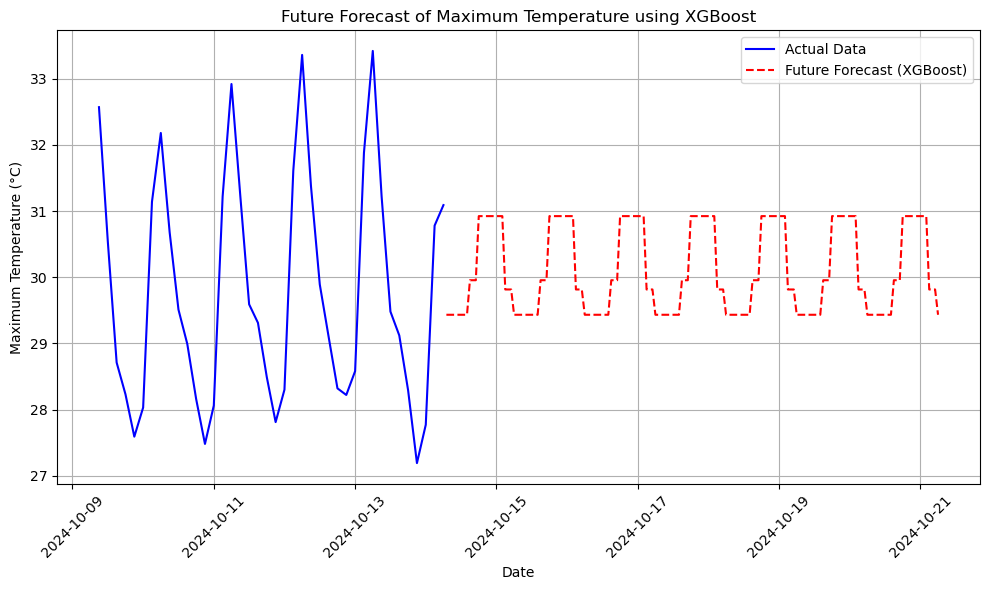

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(data['Temp_Max'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Future Forecast (XGBoost)', color='red', linestyle='--')
plt.title('Future Forecast of Maximum Temperature using XGBoost')
plt.xlabel('Date')
plt.ylabel('Maximum Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()